In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# The frequency of a Ricker wavelet

We often use Ricker wavelets to model seismic, for example when making a synthetic seismogram with which to help tie a well. One simple way to guesstimate the peak or central frequency of the wavelet that will model a particlar seismic section is to count the peaks per unit time in the seismic. But this tends to overestimate the actual frequency because the maximum [frequency](http://www.subsurfwiki.org/wiki/Frequency) of [a Ricker wavelet](http://subsurfwiki.org/wiki/Ricker_wavelet) is more than the peak frequency. The question is, how much more?

To investigate, let's make a Ricker wavelet and see what it looks like in the time and frequency domains.

In [2]:
T, dt, f = 0.256, 0.001, 25

import bruges
w, t = bruges.filters.ricker(T, dt, f, return_t=True)

import scipy.signal
f_W, W = scipy.signal.welch(w, fs=1/dt, nperseg=256)

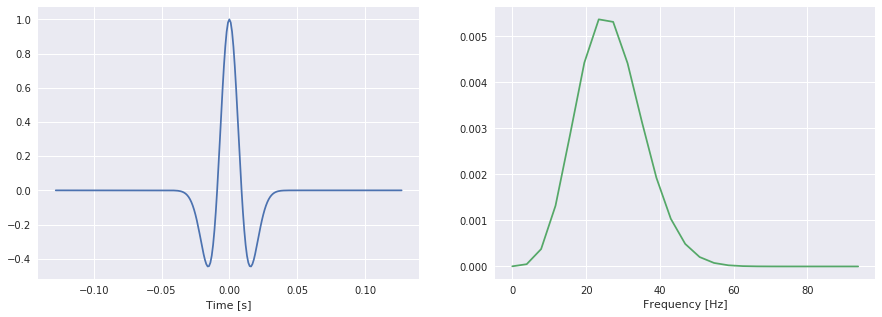

In [3]:
fig, axs = plt.subplots(figsize=(15,5), ncols=2)
axs[0].plot(t, w)
axs[0].set_xlabel("Time [s]")
axs[1].plot(f_W[:25], W[:25], c="C1")
axs[1].set_xlabel("Frequency [Hz]")
plt.show()

When we count the peaks in a section, the assumption is that this apparent frequency &mdash; that is, the reciprocal of apparent period or distance between the extrema &mdash; tells us the dominant or peak frequency.

To help see why this assumption is wrong, let's compare the Ricker with a signal whose apparent frequency does match its peak frequency: a pure cosine:

In [4]:
c = np.cos(2*25*np.pi*t)

f_C, C = scipy.signal.welch(c, fs=1/dt, nperseg=256)

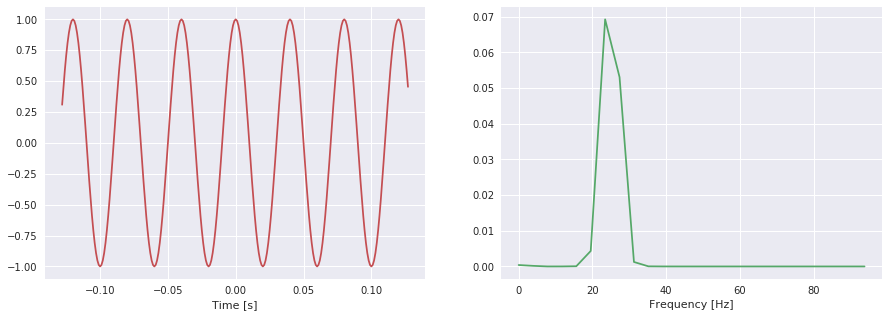

In [5]:
fig, axs = plt.subplots(figsize=(15,5), ncols=2)
axs[0].plot(t, c, c="C2")
axs[0].set_xlabel("Time [s]")
axs[1].plot(f_C[:25], C[:25], c="C1")
axs[1].set_xlabel("Frequency [Hz]")
plt.show()

Notice that the signal is much narrower in bandwidth. If we allowed more oscillations, it would be even narrower. If it lasted forever, it would be a spike in the frequency domain.

Let's overlay the signals to get a picture of the difference in the relative periods:

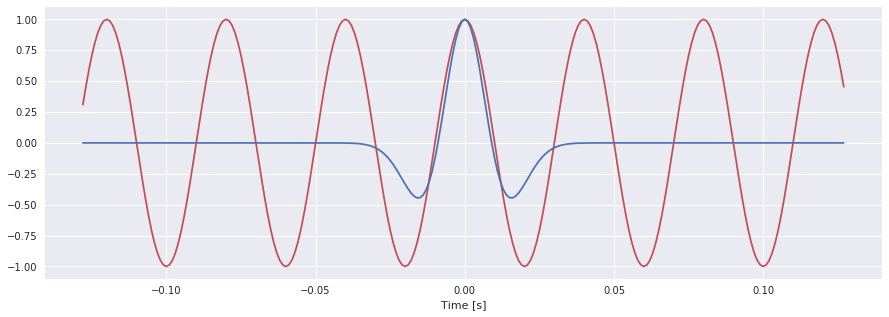

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(t, c, c='C2')
plt.plot(t, w)
plt.xlabel("Time [s]")
plt.show()

The practical consequence of this is that if we estimate the peak frequency to be $f\ \mathrm{Hz}$, then we need to reduce $f$ by some factor if we want to design a wavelet to match the data. To get this factor, we need to know the apparent period of the Ricker function, as given by the time difference between the two minima.

Let's look at a couple of different ways to find those minima: numerically and analytically.

## Find minima numerically

We'll use [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) to find a numerical solution. In order to use it, we'll need a slightly different expression for the Ricker function &mdash; casting it in terms of a time basis `t`. We'll also keep `f` as a variable, rather than hard-coding it in the expression, to give us the flexibility of computing the minima for different values of `f`. 

Here's the equation we're implementing:

$$w(t, f) = (1 - 2\pi^2 f^2 t^2)\ e^{-\pi^2 f^2 t^2}$$

In [7]:
def ricker(t, f):
    return (1 - 2*(np.pi*f*t)**2) * np.exp(-(np.pi*f*t)**2)

Check that the wavelet looks like it did before, by comparing the output of this function when `f` is 25 with the wavelet `w` we were using before:

In [8]:
f = 25
np.allclose(w, ricker(t, f=25))

True

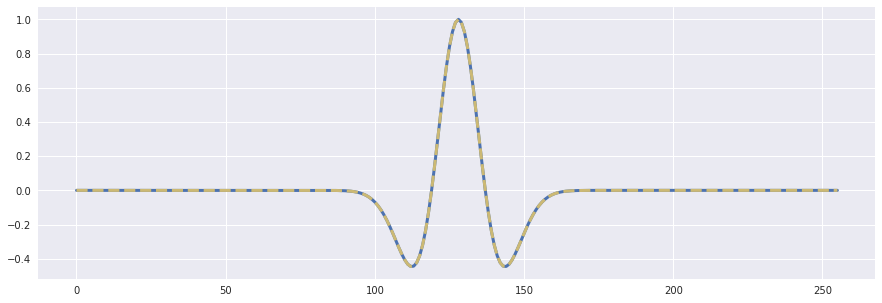

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(w, lw=3)
plt.plot(ricker(t, f), '--', c='C4', lw=3)
plt.show()

Now we call SciPy's `minimize` function on our `ricker` function. It itertively searches for a minimum solution, then gives us the `x` (which is really `t` in our case) at that minimum:

In [10]:
import scipy.optimize

f = 25

scipy.optimize.minimize(ricker, x0=0, args=(f))

      fun: -0.4462603202963996
 hess_inv: array([[1]])
      jac: array([-2.19792128e-07])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 1
     njev: 10
   status: 0
  success: True
        x: array([0.01559393])

So the minimum amplitude, given by `fun`, is $-0.44626$ and it occurs at an `x` (time) of $\pm 0.01559\ \mathrm{s}$. 

In comparison, the minima of the cosine function occur at a time of $\pm 0.02\ \mathrm{s}$. In other words, the period appears to be $0.02 - 0.01559 = 0.00441\ \mathrm{s}$ shorter than the pure waveform, which is...

In [11]:
(0.02 - 0.01559) / 0.02

0.22050000000000003

...about 22% shorter. This means that if we naively estimate frequency by counting peaks or zero crossings, we'll tend to overestimate the peak frequency of the wavelet by about 22% &mdash; assuming it is approximately Ricker-like; if it isn't we can use the same method to estimate the error for other functions.

This is good to know, but it would be interesting to know if this parameter depends on frequency, and also to have a more precise way to describe it than a decimal. To get at these questions, we need an analytic solution.

## Find minima analytically

Python's [SymPy package](http://sympy.org/) is a bit like Maple &mdash; it understands math symbolically. We'll use [`sympy.solve`](http://docs.sympy.org/latest/modules/solvers/solvers.html) to find an analytic solution. It turns out that it needs the Ricker function writing in yet another way, using SymPy symbols and expressions for $\mathrm{e}$ and $\pi$. 

In [12]:
import sympy as sp

t = sp.Symbol('t')
f = sp.Symbol('f')

r = (1 - 2*(sp.pi*f*t)**2) * sp.exp(-(sp.pi*f*t)**2)

Now we can easily find the solutions to the Ricker equation, that is, the times at which the function is equal to zero:

In [13]:
sp.solvers.solve(r, t)

[-sqrt(2)/(2*pi*f), sqrt(2)/(2*pi*f)]

But this is not quite what we want. We need the minima, not the zero-crossings.

Maybe there's a better way to do this, but here's one way. Note that the gradient (slope or derivative) of the Ricker function is zero at the minima, so let's just solve the first time derivative of the Ricker function. That will give us the three times at which the function has a gradient of zero.

In [14]:
dwdt = sp.diff(r, t)
sp.solvers.solve(dwdt, t)

[0, -sqrt(6)/(2*pi*f), sqrt(6)/(2*pi*f)]

In other words, the non-zero minima of the Ricker function are at:

$$\pm \frac{\sqrt{6}}{2\pi f}$$

Let's just check that this evaluates to the same answer we got from `scipy.optimize`, which was 0.01559.

In [15]:
np.sqrt(6) / (2 * np.pi * 25)

0.015593936024673521

The solutions agree.

While we're looking at this, we can also compute the analytic solution to the amplitude of the minima, which SciPy calculated as -0.446. We just substitute one of the expressions for the minimum time into the expression for `r`:

In [16]:
r.subs({t: sp.sqrt(6)/(2*sp.pi*f)})

-2*exp(-3/2)

## Apparent frequency

So what's the result of all this? What's the correction we need to make?

The minima of the Ricker wavelet are $\sqrt{6}\ /\ \pi f_\mathrm{actual}\ \mathrm{s}$ apart &mdash; this is the apparent period. If we're assuming a pure tone, this period corresponds to an apparent frequency of $\pi f_\mathrm{actual}\ /\ \sqrt{6}\ \mathrm{Hz}$. For $f = 25\ \mathrm{Hz}$, this apparent frequency is:

In [17]:
(np.pi * 25) / np.sqrt(6)

32.06374575404661

If we were to try to model the data with a Ricker of 32 Hz, the frequency will be too high. We need to multiply the frequency by a factor of $\sqrt{6} / \pi$, like so:

In [18]:
32.064 * np.sqrt(6) / (np.pi)

25.00019823475659

This gives the correct frequency of 25 Hz.

To sum up, rearranging the expression above:

$$f_\mathrm{actual} = f_\mathrm{apparent} \frac{\sqrt{6}}{\pi}$$

Expressed as a decimal, the factor we were seeking is therefore $\sqrt{6}\ /\ \pi$:

In [19]:
np.sqrt(6) / np.pi

0.779696801233676

That is, the reduction factor is 22%.

----

Curious coincidence: in [the recent Pi Day post](https://agilescientific.com/blog/2018/3/14/happy-pi-day-einstein), I mentioned the Riemann zeta function of 2 as a way to compute pi. It evaluates to $(\pi / \sqrt{6})^2$. Is there a connection between the Ricker wavelet and the Riemann hypothesis?

I doubt it.